# Latency Model for the RADOS Simulator
The latency model `latModel` has two components: one for converting request size into latency and another one to add compaction delays drawn from a heavy-tailed distribution (e.g. `random.lognormvariate(mu, sigma)`). See `scripts/radossim.py` for more details.

In [1]:
# Basic parameters
runs = 11

# latModel parameters (Fit those to an actual BlueStore deployment!)

# Log fitting for IO sizes > 64KB
lgMult = 820.28
lgAdd = -1114.3

# Linear fitting for IO sizes <= 64KB
smMult = 62.36
smAdd = 8.33

# Lognormal fitting to "In each second, at least 10 x 60ms are spent
# with the drive being blocked [skourtis:inflow13, Fig 4]"
# A rough example approximation would be an average around 10ms (i.e. 100 reqs/sec)
# with a 90%-tile around 60ms (so 10 of the 100 req/sec are at least 60ms)
# with the 99%-tile not too much higher. It all depends on the minimum throughput
mu = 9.9
sigma = 0.64

# Test for larger parameters
test_list = []


In [24]:
# Parameters
lgMult = 820.28
lgAdd = -1114.3
smMult = 62.36
smAdd = 8.33
mu = 6.0
sigma = 2.0


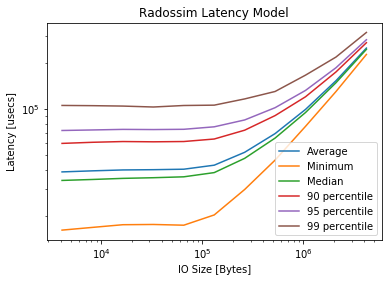

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Add path for modules in scripts/ so this notebook works
# without the context created by main.workflow
import sys
sys.path.append('../..')

import scripts.radossim as sim


x = []
y_min = []
y_avg = []
y_med = []
y_p90 = []
y_p95 = []
y_p99 = []
for i in range(runs):
    s = (2**i) * 4096
    x.append(s)
    msmts = []
    for j in range(10000):
        msmts.append(sim.latModel(s, lgMult, lgAdd, smMult, smAdd, mu, sigma))
    msmts.sort()
    avg = sum(msmts) / len(msmts)
    median = msmts[int(.5 * len(msmts))]
    pct90 = msmts[int(.90 * len(msmts))]
    pct95 = msmts[int(.95 * len(msmts))]
    pct99 = msmts[int(.99 * len(msmts))]
    y_min.append(msmts[0])
    y_avg.append(avg)
    y_med.append(median)
    y_p90.append(pct90)
    y_p95.append(pct95)
    y_p99.append(pct99)
    
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, y_avg, label='Average')
ax.plot(x, y_min, label='Minimum')
ax.plot(x, y_med, label='Median')
ax.plot(x, y_p90, label='90 percentile')
ax.plot(x, y_p95, label='95 percentile')
ax.plot(x, y_p99, label='99 percentile')
ax.set(xlabel='IO Size [Bytes]', ylabel='Latency [usecs]', title='Radossim Latency Model')

plt.legend()
plt.show()

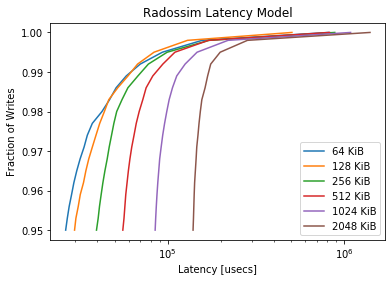

In [14]:
data = {}
for i in range(6):
    s = (2**i) * 64 * 1024
    msmts = []
    for j in range(10000):
        msmts.append(sim.latModel(s, lgMult, lgAdd, smMult, smAdd, mu, sigma))
    msmts.sort()
    data[s] = msmts

curve = {}
for i in range(6):
    s = (2**i) * 64 * 1024
    x = []
    y = []
    for i in range(950, 1000, 3):
        x.append(data[s][int(i/1000. * len(data[s]))])
        y.append(i/1000.)
    x.append(data[s][-1])
    y.append(1.0)
    curve[s] = (x, y)

fig, ax = plt.subplots()
ax.set_xscale('log')
for s in curve.keys():
    ax.plot(curve[s][0], curve[s][1], label='%d KiB' % (s / 1024))
ax.set(xlabel='Latency [usecs]', ylabel='Fraction of Writes', title='Radossim Latency Model')
plt.legend()
plt.show()

The following is an analysis of raw data taken from Bluestore (see PR 14). The raw data of commit latencies are in `experiments/latModel/BlueStore/base-batch-1/dump_kv_sync_lat_vec-*.csv` (one file per request size). 

First a look at any trends over time:

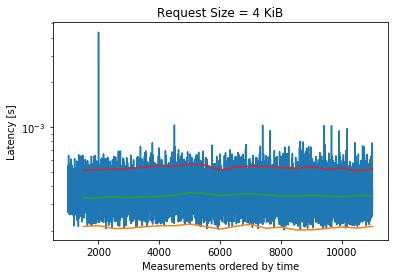

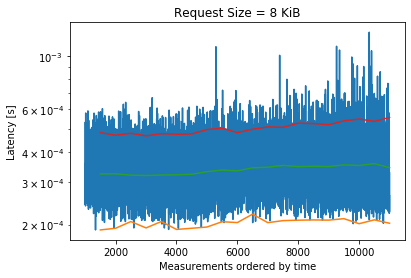

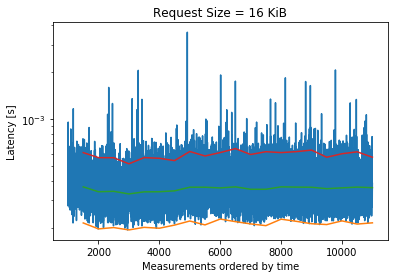

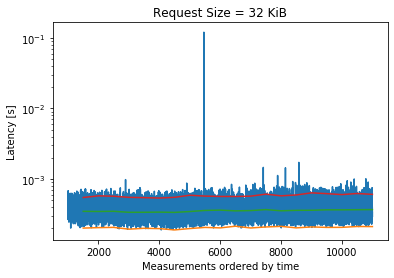

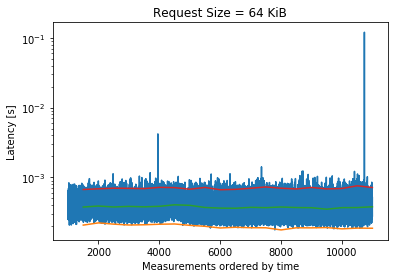

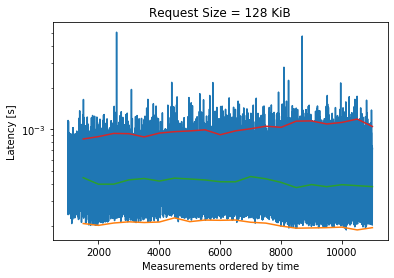

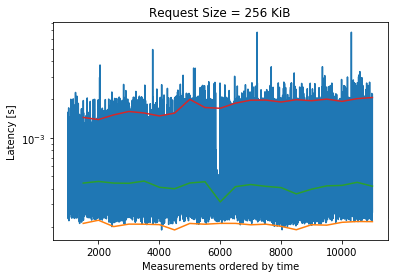

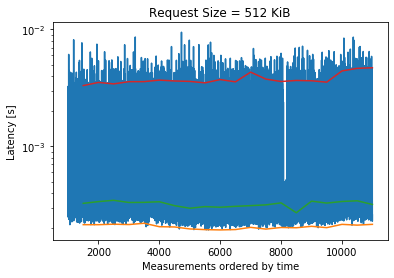

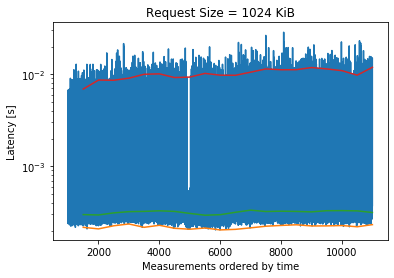

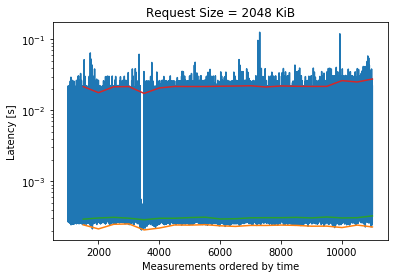

In [3]:
import matplotlib
import matplotlib.pyplot as plt

for i in range(10):
    s = (2**i) * 4096
    fd = open('BlueStore/base-batch-1/dump_kv_sync_lat_vec-%d.csv' % s)
    x = []
    y = []
    sum_x = []
    min_y = []
    median_y = []
    p95_y = []
    win = []
    # Throw away title line and some initial number of measurements
    fd.readline()
    for j in range(1001):
        fd.readline()
    while fd and j < 11000:
        lat = fd.readline()
        try:
            lat = float(lat.strip())
        except ValueError:
            continue
        x.append(j)
        y.append(lat)
        win.append(lat)
        j += 1
        if j % 500 == 0:
            win.sort()
            median = win[int(len(win) * .5)]
            p95 = win[int(len(win) * .95)]
            sum_x.append(j)
            min_y.append(win[0])
            median_y.append(median)
            p95_y.append(p95)
            win = []
    fd.close()
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.plot(x, y)
    ax.plot(sum_x, min_y)
    ax.plot(sum_x, median_y)
    ax.plot(sum_x, p95_y)
    ax.set(xlabel='Measurements ordered by time', ylabel='Latency [s]', title='Request Size = %d KiB' % (s / 1024))
    plt.show()

The above results seem to indicate that removing the first 1000 measurements skips most of the start-up effects. There are still some trends over time but the data is probably good enough for calibrating the radossim latModel.

The next step is to start calibrating the radossim latModel. Let's start with 4KiB ...

minimum predicted latency: 16310.103253
minimum actual latency: 202.061000
KS Test: Ks_2sampResult(statistic=1.0, pvalue=0.0)
critical values (alpha, value): (0.05, 0.019205020177026633) (0.01, 0.023023396795433988)


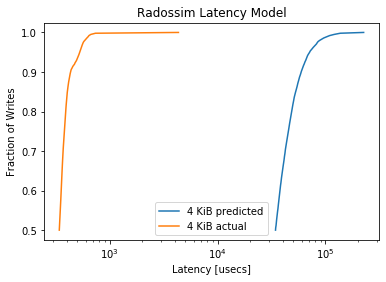

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import math

# Add path for modules in scripts/ so this notebook works
# without the context created by main.workflow
import sys
sys.path.append('../..')

import scripts.radossim as sim

def validateMod(reqSize, lgMult, lgAdd, smMult, smAdd, mu, sigma, start=500):
    
    # Create 10,000 latModel latency predictions for size = 4KiB 
    pred_samples = []
    for j in range(10000):
        pred_samples.append(sim.latModel(reqSize, lgMult, lgAdd, smMult, smAdd, mu, sigma))
    pred_samples.sort()
    pred_min = pred_samples[0]
    print('minimum predicted latency: %f' % pred_min)

    # Create percentile curve for latency predictions
    pred_x = []
    y = []
    for i in range(start, 1000, 3):
        pred_x.append(pred_samples[int(i/1000. * len(msmts))])
        y.append(i/1000.)
    pred_x.append(pred_samples[-1])
    y.append(1.0)

    # Create percentile curve for actual latency measurements
    fd = open('BlueStore/base-batch-1/dump_kv_sync_lat_vec-%d.csv' % reqSize)

    # Skip the title and the first 1000 measurements
    for i in range(1001):
        fd.readline()
    
    # Collect 10000 measurements
    act_samples = []
    for i in range(10000):
        lat = fd.readline()
        try:
            lat = float(lat.strip())
        except ValueError:
            continue
        # assume these are seconds -- convert to microseconds
        act_samples.append(lat * 10**6)
    act_samples.sort()
    act_min = act_samples[0]
    print('minimum actual latency: %f' % act_min)

    act_x = []
    for i in range(start, 1000, 3):
        act_x.append(act_samples[int(i/1000. * len(msmts))])
    act_x.append(act_samples[-1])
    
    # KS test
    ks_test = ks_2samp(pred_samples, act_samples)
    print('KS Test:', ks_test)
    print('critical values (alpha, value):', 
          (0.05, 1.358 * math.sqrt((2 * 10000)/(10000**2))),
          (0.01, 1.628 * math.sqrt((2 * 10000)/(10000**2))))

    # Plot both curves
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.plot(pred_x, y, label='%d KiB predicted' % (reqSize / 1024))
    ax.plot(act_x, y, label='%d KiB actual' % (reqSize / 1024))

    ax.set(xlabel='Latency [usecs]', ylabel='Fraction of Writes', title='Radossim Latency Model')
    plt.legend()
    plt.show()
    
    return (pred_min, act_min, ks_test)

(pred_min, act_min, ks_test) = validateMod(4096, lgMult, lgAdd, smMult, smAdd, mu, sigma)

minimum predicted latency: 1639.925296
minimum actual latency: 202.061000
KS Test: Ks_2sampResult(statistic=0.9999, pvalue=0.0)
critical values (alpha, value): (0.05, 0.019205020177026633) (0.01, 0.023023396795433988)


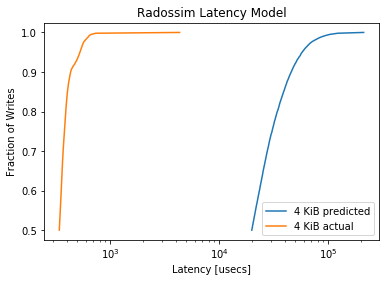

(1639.925295620003,
 202.06099999999998,
 Ks_2sampResult(statistic=0.9999, pvalue=0.0))

In [5]:
# Yikes! Almost by 2 orders of magnitude off (assuming the raw data is in seconds). 
# Let's start tweaking the model by adjusting smAdd

validateMod(4096, lgMult, lgAdd, smMult, smAdd * 580, mu, sigma)


minimum predicted latency: 228.674600
minimum actual latency: 202.061000
KS Test: Ks_2sampResult(statistic=0.1461, pvalue=1.870726129804295e-93)
critical values (alpha, value): (0.05, 0.019205020177026633) (0.01, 0.023023396795433988)


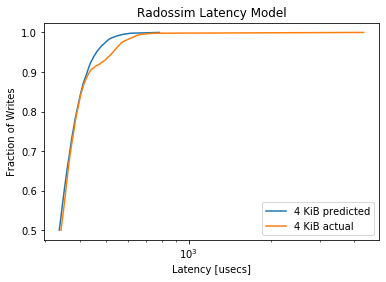

(228.67460030453205,
 202.06099999999998,
 Ks_2sampResult(statistic=0.1461, pvalue=1.870726129804295e-93))

In [6]:
# Good enough. Next is task is to fit the probabilistic component of latModel 
# to the observed distribution.

validateMod(4096, lgMult, lgAdd, smMult, smAdd * 580, 4.9, .4)

Not bad. There is a mismatch above the 90-percentile. And the minimum predicted latency drifted up. So let's fix the latter first by manipulating `smAdd`.

minimum predicted latency: 202.268038
minimum actual latency: 202.061000
KS Test: Ks_2sampResult(statistic=0.1147, pvalue=1.1010000860636555e-57)
critical values (alpha, value): (0.05, 0.019205020177026633) (0.01, 0.023023396795433988)


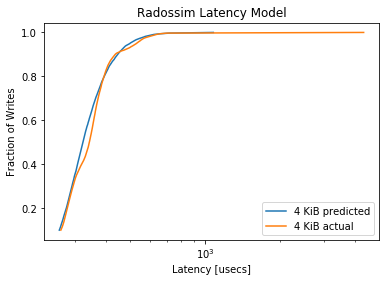

(202.26803833200245,
 202.06099999999998,
 Ks_2sampResult(statistic=0.1147, pvalue=1.1010000860636555e-57))

In [18]:
validateMod(4096, lgMult, lgAdd, smMult, smAdd * 628, 4.9, .5, start=100)

This looks _visually_ like a good fit but the K-S test shows that we still need to reject the null hypothesis that both samples draw from the same distribution.